In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/validation/negative/50/grey_images/PAC_14_DN15.jpg
/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/validation/negative/50/grey_images/PAC_14_DN2.jpg
/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/validation/negative/50/grey_images/PAC_14_DN12.jpg
/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/validation/negative/50/grey_images/PAC_14_DN0.jpg
/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/validation/negative/50/grey_images/PAC_14_DN1.jpg
/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermograph

In [2]:
import os
import time
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for class_label, class_name in enumerate(["negative", "positive"]):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for subfolder in os.listdir(class_dir):
                    subfolder_path = os.path.join(class_dir, subfolder, "grey_images")
                    if os.path.exists(subfolder_path):
                        for img_name in os.listdir(subfolder_path):
                            if img_name.endswith(".jpg"):
                                img_path = os.path.join(subfolder_path, img_name)
                                self.image_paths.append(img_path)
                                self.labels.append(class_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.long)

In [5]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [6]:
# Paths (update as needed)
train_path = "/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/train"
val_path = "/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/validation"
test_path = "/kaggle/input/dmr-ir-breast-thermography-dataset/dmr-ir thermography dataset/dmr-ir thermography dataset/dmr-ir thermography/test"


In [7]:
# Create Dataset Instances
train_dataset = BreastCancerDataset(train_path, transform=train_transform)
val_dataset = BreastCancerDataset(val_path, transform=val_test_transform)
test_dataset = BreastCancerDataset(test_path, transform=val_test_transform)


print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Number of training images: 663
Number of validation images: 261
Number of test images: 204


In [8]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 100

In [9]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [10]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Channel-wise average
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Channel-wise max
        x_cat = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]
        attention = self.sigmoid(self.conv(x_cat))  # [B, 1, H, W]
        return x * attention  # Apply attention

In [11]:
from torchvision.models.mobilenetv2 import InvertedResidual

class InvertedResidualWithSpatialAttention(nn.Module):
    def __init__(self, block: InvertedResidual, spatial_attention: nn.Module):
        super().__init__()
        self.block = block
        self.spatial_attention = spatial_attention

    def forward(self, x):
        out = self.block(x)
        out = self.spatial_attention(out)
        return out

In [12]:
from torchvision.models import mobilenet_v2

class MobileNetV2_SpatialAttention(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV2_SpatialAttention, self).__init__()
        base_model = mobilenet_v2(pretrained=False)

        self.features = nn.Sequential()
        for i, block in enumerate(base_model.features):
            if isinstance(block, InvertedResidual):
                attention = SpatialAttention()
                block_with_attention = InvertedResidualWithSpatialAttention(block, attention)
                self.features.add_module(f"block{i}", block_with_attention)
            else:
                self.features.add_module(f"block{i}", block)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(base_model.last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
model = MobileNetV2_SpatialAttention(num_classes=2).to(device)

# Example training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
model

MobileNetV2_SpatialAttention(
  (features): Sequential(
    (block0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (block1): InvertedResidualWithSpatialAttention(
      (block): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (spatial_attention): SpatialAttention(
        (conv): Conv2d(2, 1, kernel_size=(7, 7), stride

In [15]:
# Evaluation Function
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    validation_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return validation_loss, 100 * correct / total, all_labels, all_preds

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_acc = 0.0
    best_model_path = "./best_mobilenet_spatial.pth"
    min_validation = 9999
    start_time = time.time()

    train_loss_vs_epoch = []
    val_loss_vs_epoch = []

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader)

        if val_loss < min_validation:
            min_validation = val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Model saved.")

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

        train_loss_vs_epoch.append(running_loss / len(train_loader))
        val_loss_vs_epoch.append(val_loss / len(val_loader))

    print(f"Training completed in {time.time() - start_time:.2f} seconds")

    # Plot loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss_vs_epoch, 'r-', label='Train Loss')
    plt.plot(val_loss_vs_epoch, 'b-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.savefig("loss_plot.png")
    plt.close()

In [17]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Model saved.
Epoch [1/100] - Train Loss: 0.6443, Train Acc: 66.82%, Val Loss: 0.6460, Val Acc: 61.69%
Epoch [2/100] - Train Loss: 0.6222, Train Acc: 66.67%, Val Loss: 0.6493, Val Acc: 61.69%
Epoch [3/100] - Train Loss: 0.5913, Train Acc: 68.78%, Val Loss: 0.6804, Val Acc: 61.69%
Model saved.
Epoch [4/100] - Train Loss: 0.5258, Train Acc: 74.36%, Val Loss: 0.5362, Val Acc: 70.88%
Model saved.
Epoch [5/100] - Train Loss: 0.4751, Train Acc: 77.07%, Val Loss: 0.3664, Val Acc: 80.46%
Model saved.
Epoch [6/100] - Train Loss: 0.3909, Train Acc: 82.05%, Val Loss: 0.2487, Val Acc: 89.27%
Epoch [7/100] - Train Loss: 0.3825, Train Acc: 82.81%, Val Loss: 0.3282, Val Acc: 84.29%
Epoch [8/100] - Train Loss: 0.2962, Train Acc: 87.78%, Val Loss: 0.3403, Val Acc: 82.38%
Epoch [9/100] - Train Loss: 0.2939, Train Acc: 87.63%, Val Loss: 0.3267, Val Acc: 85.82%
Epoch [10/100] - Train Loss: 0.2673, Train Acc: 88.54%, Val Loss: 0.3061, Val Acc: 89.27%
Epoch [11/100] - Train Loss: 0.2840, Train Acc: 87.63%, V

In [18]:
# Load Best Model
model.load_state_dict(torch.load("best_mobilenet_spatial.pth"))

/tmp/ipykernel_19/3545553896.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mobilenet_spatial.pth"))


<All keys matched successfully>


Test Accuracy: 95.10%
              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92        61
    Positive       0.97      0.97      0.97       143

    accuracy                           0.95       204
   macro avg       0.94      0.94      0.94       204
weighted avg       0.95      0.95      0.95       204



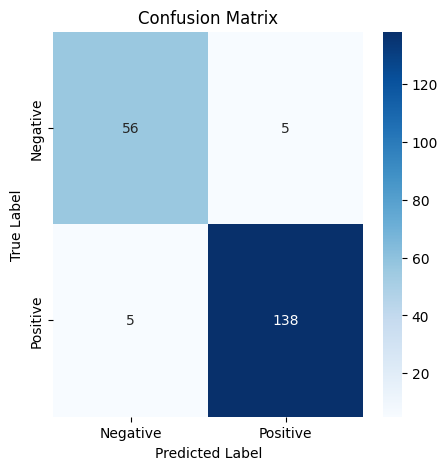

In [19]:
# Test Function
def test_model(model, loader):
    model.eval()
    correct, total = 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    return 100 * correct / total, all_labels, all_preds

# Evaluate
test_acc, test_labels, test_preds = test_model(model, test_loader)
print(f'\nTest Accuracy: {test_acc:.2f}%')
print(classification_report(test_labels, test_preds, target_names=["Negative", "Positive"]))

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Confusion Matrix - Train


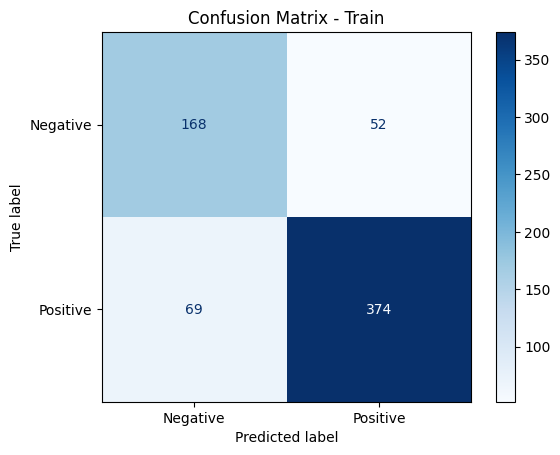

 Confusion Matrix - Validation


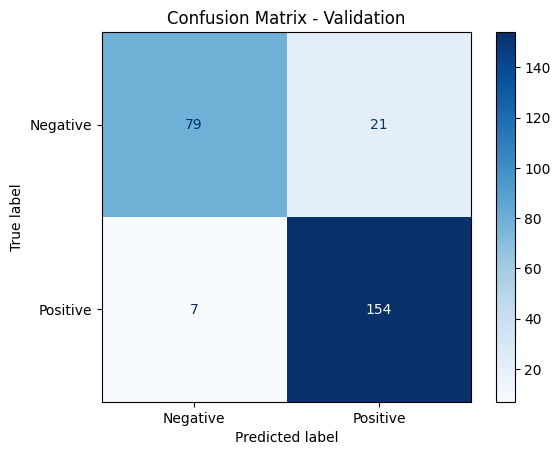

Confusion Matrix - Test


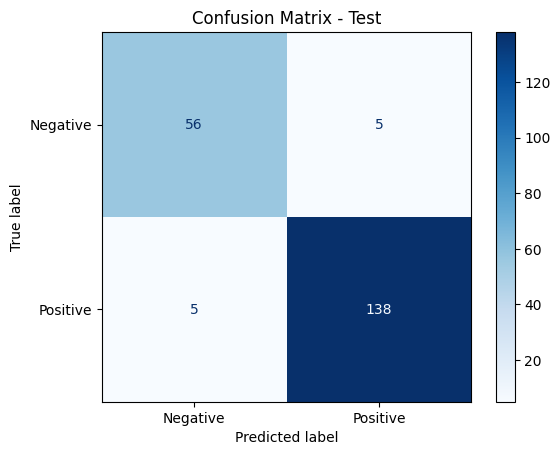

In [20]:
# Evaluate all sets
train_loss, train_acc, train_labels, train_preds = evaluate_model(model, train_loader)
val_loss, val_acc, val_labels, val_preds = evaluate_model(model, val_loader)

# -------------------- CONFUSION MATRICES --------------------
def show_confusion_matrix(true, pred, title):
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

print("Confusion Matrix - Train")
show_confusion_matrix(train_labels, train_preds, "Train")

print(" Confusion Matrix - Validation")
show_confusion_matrix(val_labels, val_preds, "Validation")

print("Confusion Matrix - Test")
show_confusion_matrix(test_labels, test_preds, "Test")


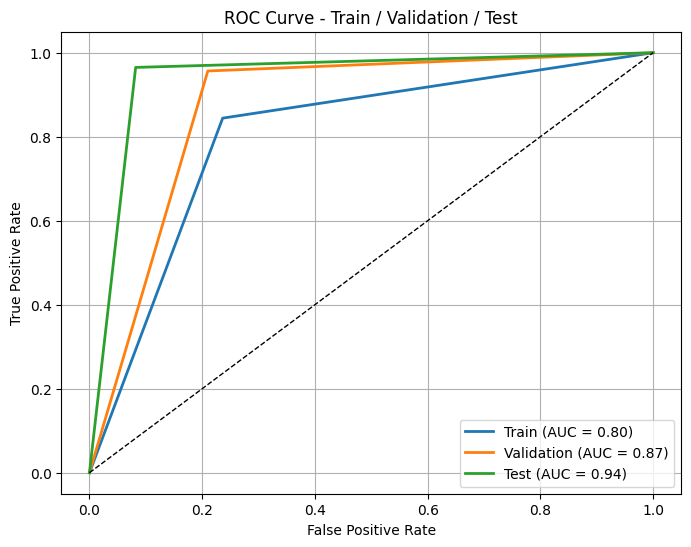

In [21]:
def plot_roc(true, pred, title):
    # Binarize the true and predicted values (0 or 1)
    true = label_binarize(true, classes=[0, 1])
    pred = label_binarize(pred, classes=[0, 1])
    
    fpr, tpr, _ = roc_curve(true, pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f'{title} (AUC = {roc_auc:.2f})')

# Plot ROC curves
plt.figure(figsize=(8, 6))
plot_roc(train_labels, train_preds, "Train")
plot_roc(val_labels, val_preds, "Validation")
plot_roc(test_labels, test_preds, "Test")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train / Validation / Test")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [22]:
import torch
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode

all_outputs = []  # To store outputs

with torch.no_grad():
    for images, labels in test_loader:  # Replace 'dataloader' with your DataLoader
        images = images.cuda()
        outputs = model(images)  # shape: (batch_size, 2)

        all_outputs.append(outputs.cpu())  # Save outputs (logits) to CPU memory

# Stack all outputs into a single tensor
all_outputs = torch.cat(all_outputs, dim=0)

# Optional: convert to softmax probabilities
probabilities = F.softmax(all_outputs, dim=1)

# Save to file
torch.save(probabilities, 'mobilenet_spatial_outputs.pt')


In [23]:
loaded_outputs = torch.load('mobilenet_spatial_outputs.pt')

/tmp/ipykernel_19/3494998293.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_outputs = torch.load('mobilenet_spatial_outputs.pt')


In [24]:
import torch
import torch.nn.functional as F
import pandas as pd

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Replace with your actual dataloader
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)  # Raw logits
        probs = F.softmax(outputs, dim=1)  # Convert to probabilities

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Combine everything
all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert to numpy
probs_np = all_probs.numpy()
labels_np = all_labels.numpy()

# Create DataFrame
df = pd.DataFrame(probs_np, columns=["Class_0_Pred", "Class_1_Pred"])
df["Class_0_GT"] = (labels_np == 0).astype(int)
df["Class_1_GT"] = (labels_np == 1).astype(int)
predicted_classes = all_probs.argmax(dim=1).numpy()
df["Predicted_Class"] = predicted_classes
df["Ground_Truth"] = labels_np


# Save to CSV
df.to_csv("mobilenet_spatial_predictions_with_groundtruth.csv", index=False)


In [25]:
import torch
import torch.nn.functional as F
import pandas as pd

model.eval()
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Replace with your actual DataLoader
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # Raw logits
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        preds = torch.argmax(probs, dim=1)  # Predicted class index

        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Combine outputs
all_probs = torch.cat(all_probs, dim=0)
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Create DataFrame
df = pd.DataFrame(all_probs.numpy(), columns=["Class_0_Prob", "Class_1_Prob"])
df["Predicted_Label"] = all_preds.numpy()
df["Ground_Truth_Label"] = all_labels.numpy()

# Save to CSV
df.to_csv("mobilenet_spatial_predictions_with_groundtruth1.csv", index=False)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


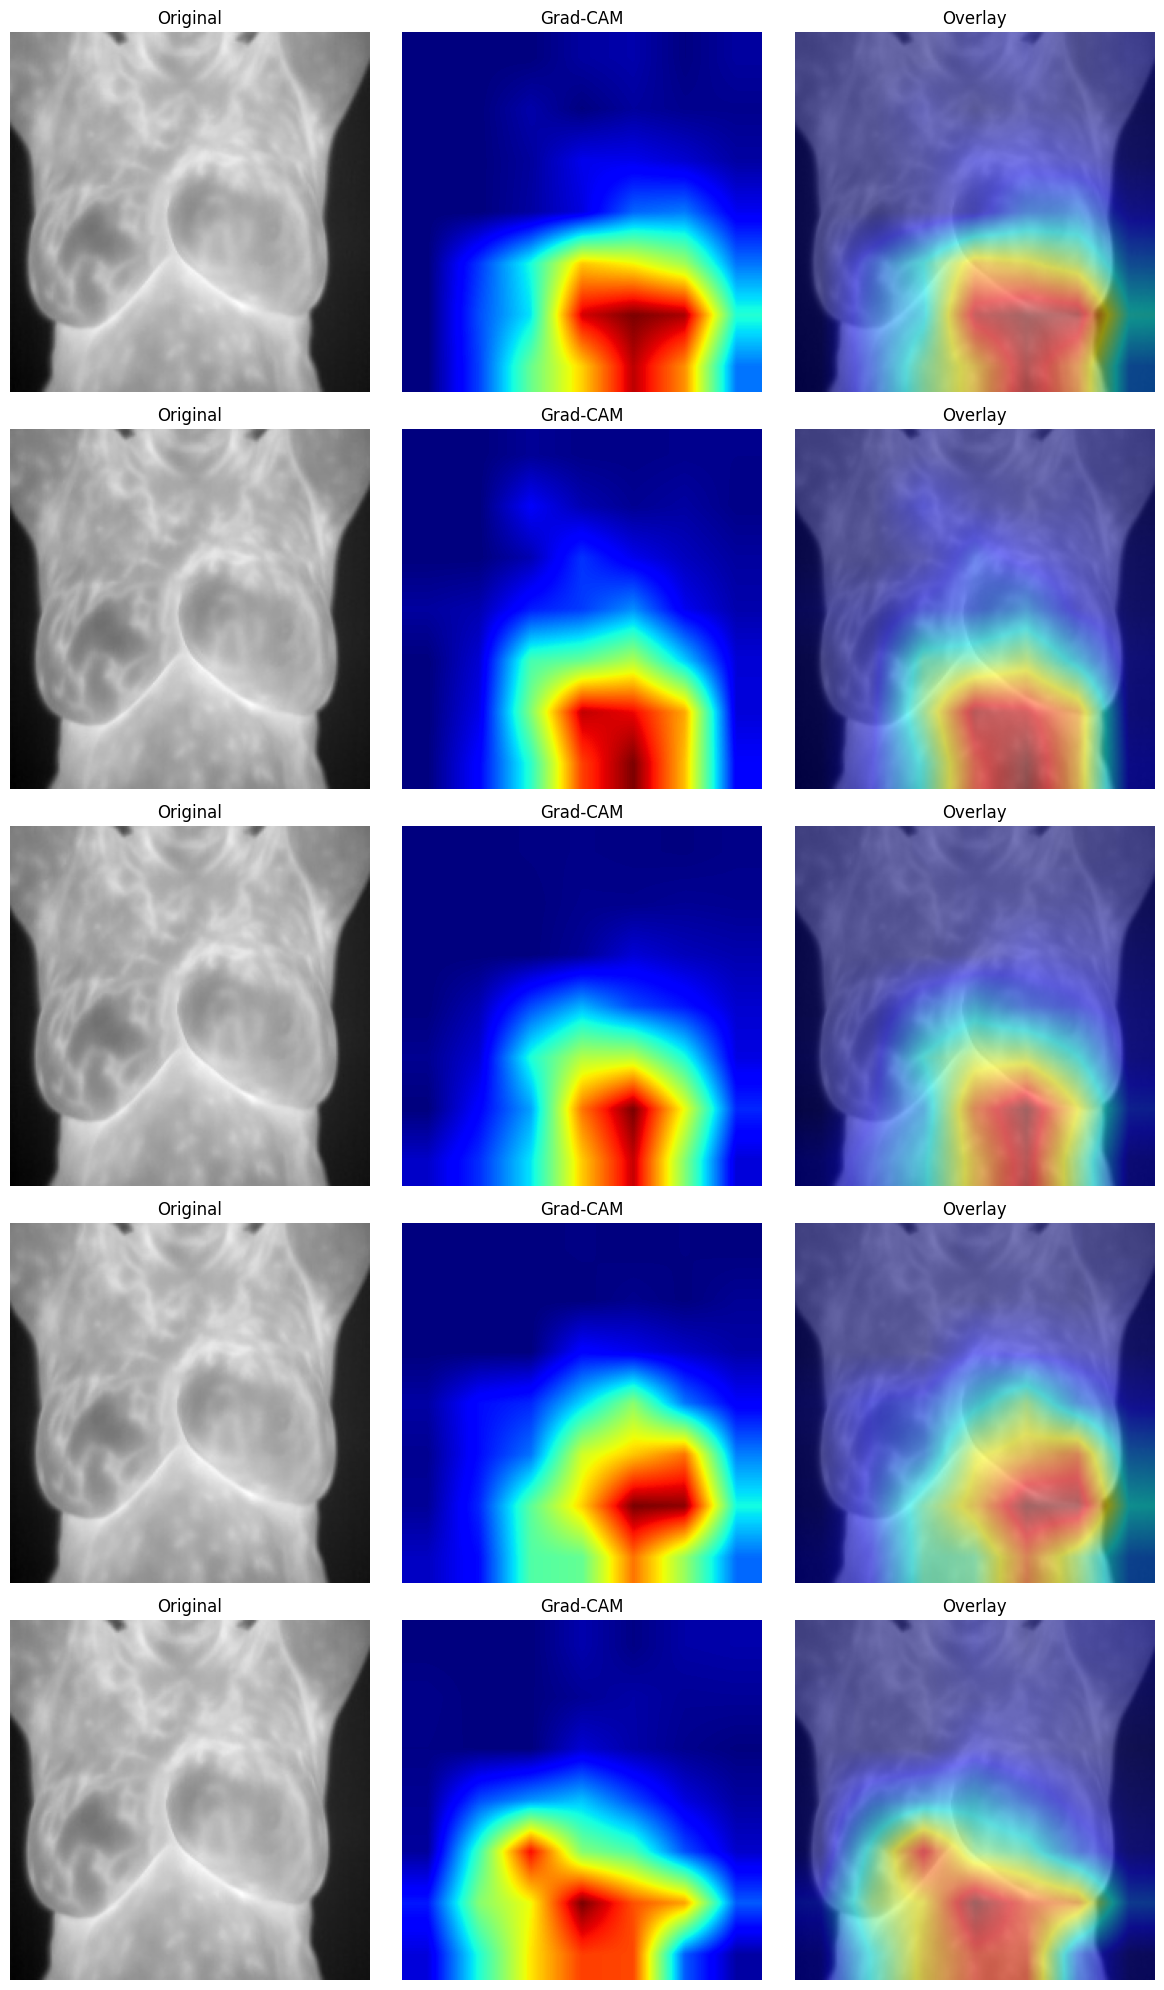

In [26]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Grad-CAM Class
# ----------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        gradients = self.gradients.detach()
        activations = self.activations.detach()
        weights = gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)

        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

# ----------------------------
# Load your custom model
# ----------------------------
# model.load_state_dict(torch.load("./best_resnet50_spatial_model.pth"))
model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.cuda()

# ----------------------------
# Set your target layer (modify this!)
# ----------------------------
# Example: CBAM or SE block output after layer4
# If it's a custom CA block inside layer4[2], adjust as needed
target_layer = target_layer = model.features[-1]  # Change this to your actual SAM layer
grad_cam = GradCAM(model, target_layer)

# ----------------------------
# Get positive test samples
# ----------------------------
num_to_display = 5
positive_images = []

with torch.no_grad():
    for images, labels in test_loader:
        for i in range(len(labels)):
            if labels[i].item() == 1:
                img_tensor = images[i].unsqueeze(0).to(device)
                orig_img = images[i].permute(1, 2, 0).cpu().numpy()
                positive_images.append((img_tensor, orig_img))
                if len(positive_images) >= num_to_display:
                    break
        if len(positive_images) >= num_to_display:
            break

# ----------------------------
# Display Grad-CAM Results
# ----------------------------
fig, axs = plt.subplots(num_to_display, 3, figsize=(12, 4 * num_to_display))

for idx, (img_tensor, orig_img) in enumerate(positive_images):
    cam = grad_cam.generate_cam(img_tensor)

    # Unnormalize original image
    orig_img = (orig_img * 0.5) + 0.5
    orig_img = np.clip(orig_img, 0, 1)

    cam_colored = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_colored = cv2.cvtColor(cam_colored, cv2.COLOR_BGR2RGB)
    cam_colored = cam_colored / 255.0

    cam_overlay = 0.5 * orig_img + 0.5 * cam_colored
    cam_overlay = np.clip(cam_overlay, 0, 1)

    axs[idx, 0].imshow(orig_img)
    axs[idx, 0].set_title("Original")
    axs[idx, 0].axis("off")

    axs[idx, 1].imshow(cam, cmap='jet')
    axs[idx, 1].set_title("Grad-CAM")
    axs[idx, 1].axis("off")

    axs[idx, 2].imshow(cam_overlay)
    axs[idx, 2].set_title("Overlay")
    axs[idx, 2].axis("off")

plt.tight_layout()
plt.show()


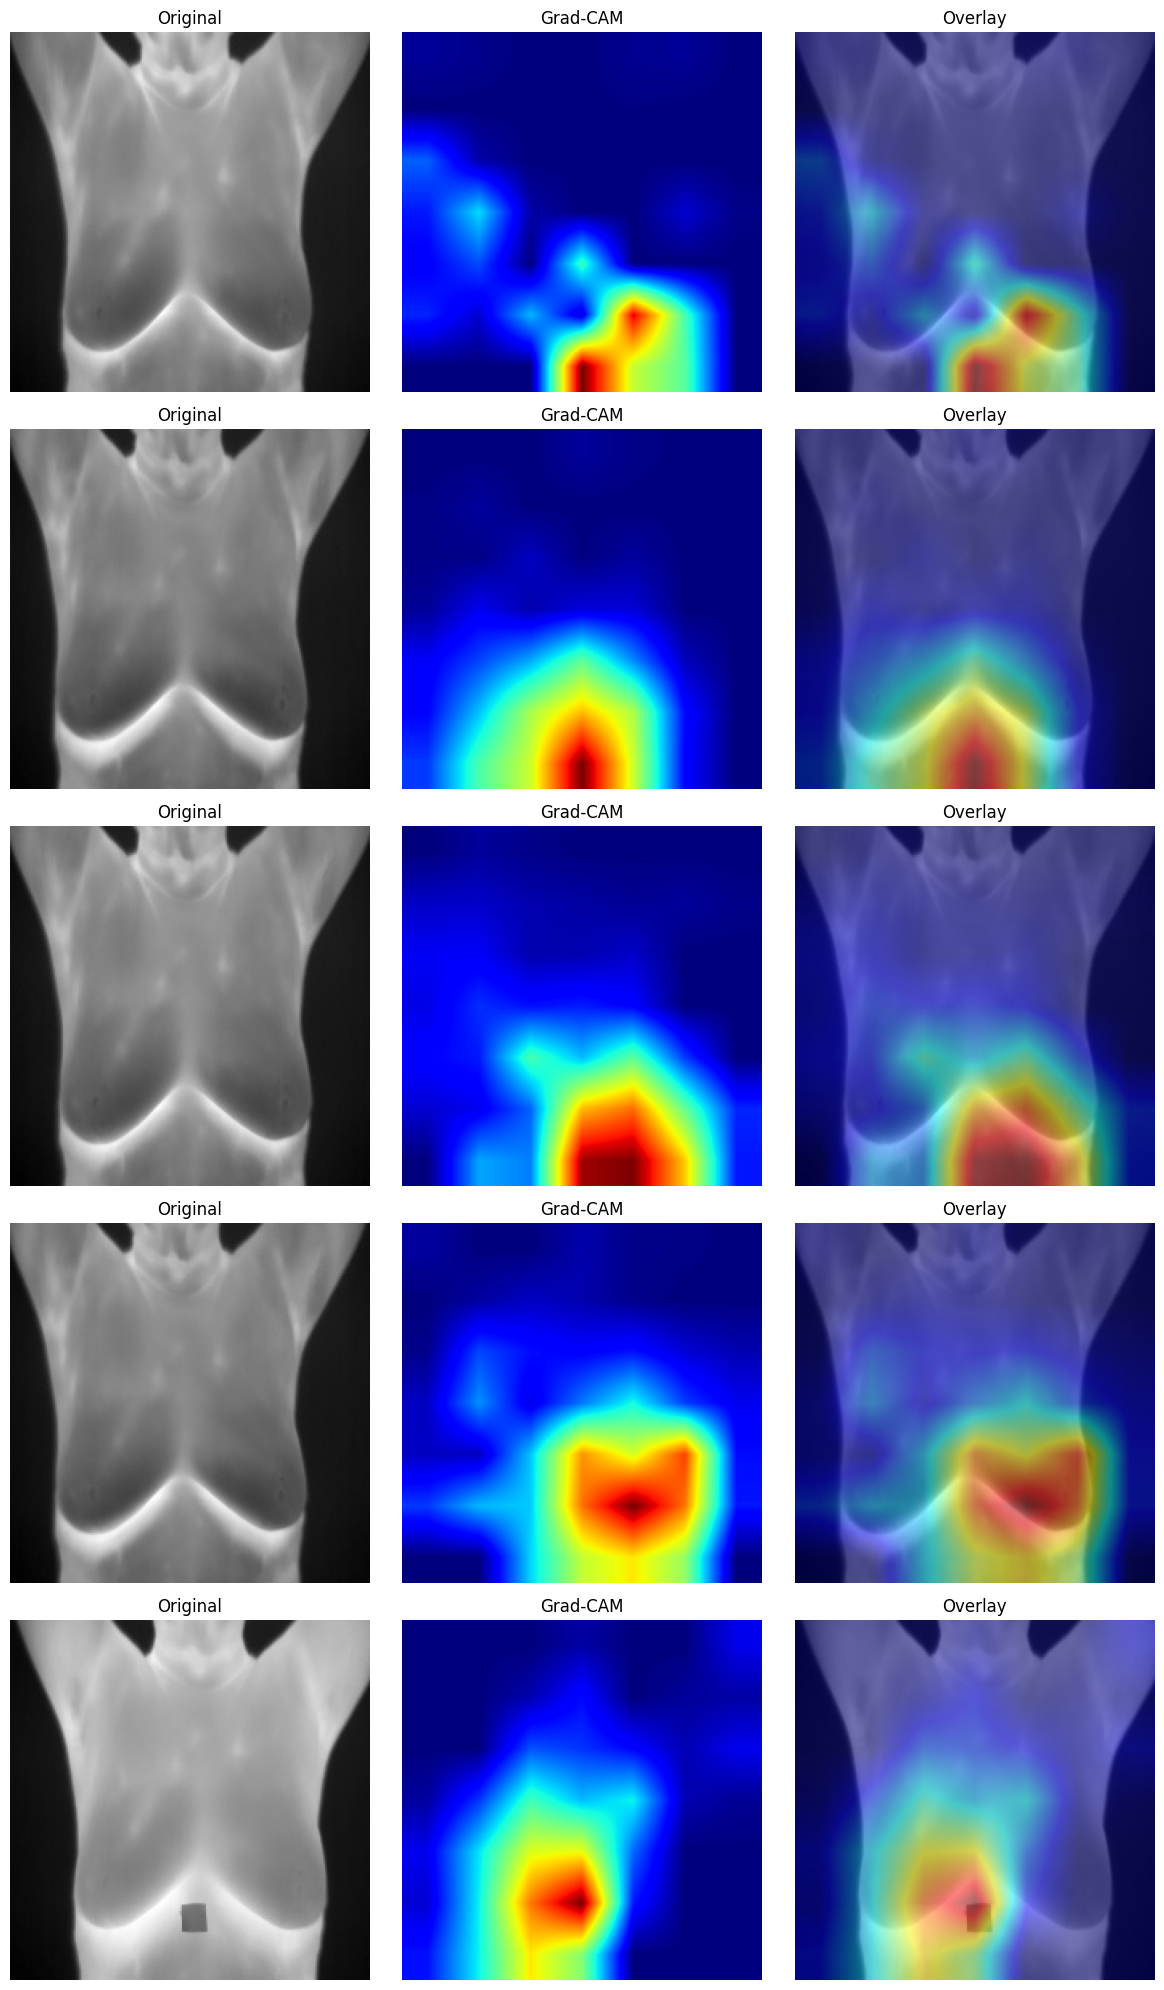

In [27]:
# ----------------------------
# Get negative test samples
# ----------------------------
num_to_display = 5
positive_images = []

with torch.no_grad():
    for images, labels in test_loader:
        for i in range(len(labels)):
            if labels[i].item() == 0:
                img_tensor = images[i].unsqueeze(0).to(device)
                orig_img = images[i].permute(1, 2, 0).cpu().numpy()
                positive_images.append((img_tensor, orig_img))
                if len(positive_images) >= num_to_display:
                    break
        if len(positive_images) >= num_to_display:
            break

# ----------------------------
# Display Grad-CAM Results
# ----------------------------
fig, axs = plt.subplots(num_to_display, 3, figsize=(12, 4 * num_to_display))

for idx, (img_tensor, orig_img) in enumerate(positive_images):
    cam = grad_cam.generate_cam(img_tensor)

    # Unnormalize original image
    orig_img = (orig_img * 0.5) + 0.5
    orig_img = np.clip(orig_img, 0, 1)

    cam_colored = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_colored = cv2.cvtColor(cam_colored, cv2.COLOR_BGR2RGB)
    cam_colored = cam_colored / 255.0

    cam_overlay = 0.5 * orig_img + 0.5 * cam_colored
    cam_overlay = np.clip(cam_overlay, 0, 1)

    axs[idx, 0].imshow(orig_img)
    axs[idx, 0].set_title("Original")
    axs[idx, 0].axis("off")

    axs[idx, 1].imshow(cam, cmap='jet')
    axs[idx, 1].set_title("Grad-CAM")
    axs[idx, 1].axis("off")

    axs[idx, 2].imshow(cam_overlay)
    axs[idx, 2].set_title("Overlay")
    axs[idx, 2].axis("off")

plt.tight_layout()
plt.show()